# 1.4 RBIG Model

In [10]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Logging

In [12]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


W&B Run: https://app.wandb.ai/emanjohnson91/rbigjax-demo-2d/runs/3rzqa63n

In [13]:

# config parameters
wandb.config.n_samples = 1_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

ERROR:wandb.jupyter:Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Data

<Figure size 432x288 with 0 Axes>

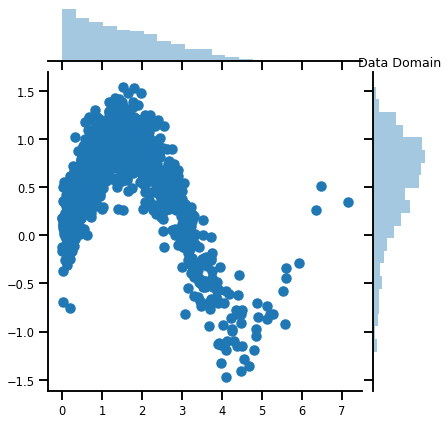

In [14]:
# %%wandb
# get data
data = get_classic(1_000)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1])
plt.title('Data Domain')
plt.show()

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [15]:
from rbig_jax.transforms.histogram import get_hist_params
from rbig_jax.transforms.uniformize import uniformize_transform
from rbig_jax.transforms.marginal import marginal_transform_params, marginal_transform
from rbig_jax.transforms.gaussianize import gaussianize_forward
from rbig_jax.transforms.gaussianize import gaussianize_marginal_transform, gaussianize_marginal_inverse

## Marginal Gaussianization Transformation

(aka element-wise transformation)

#### Histogram

In [16]:
# marginal Gaussianization parameters
support_extension = 10
alpha = 1e-5
precision = 1_000
nbins = int(np.sqrt(data.shape[0]))

histogram_uniformize = jax.partial(
    get_hist_params,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

# define our marginal uniform transform dist
uni_transform_f = jax.partial(
        marginal_transform_params, 
        function=histogram_uniformize
    )

gaussianize_f = jax.partial(gaussianize_forward, uni_transform_f=uni_transform_f)

In [18]:
from rbig_jax.transforms.rbig import (
    rbig_block_forward, 
    rbig_block_transform, 
    rbig_block_inverse
)

In [19]:
X_r, params = rbig_block_forward(data, gaussianize_f)

<Figure size 432x288 with 0 Axes>

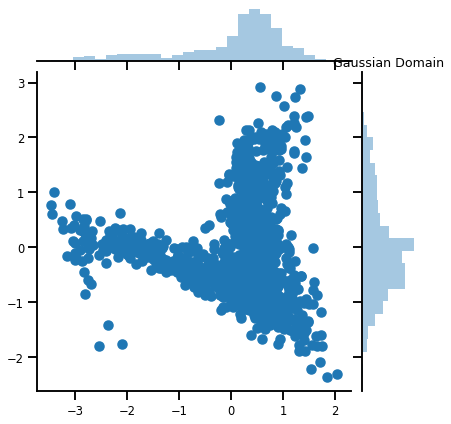

In [20]:
plt.figure()
sns.jointplot(onp.array(X_r)[:, 0], onp.array(X_r)[:, 1])
plt.title('Gaussian Domain')
plt.show()

## RBIG MODEL

In [64]:
import objax
from typing import Callable

class RBIGFlow:
    def __init__(
        self,
        gaussianize_f: Callable,
        max_layers: int = 1_000,
        jitted: bool=True
    ):
        # create Gaussinization block
        self.block_forward = jax.partial(
            rbig_block_forward, 
            marginal_gauss_f=gaussianize_f
        )
        self.block_transform = rbig_block_transform
        self.block_inverse = rbig_block_inverse
        self.max_layers = max_layers
        
        # jit arguments
        if jitted:
            self.block_forward = jax.jit(self.block_forward)
            self.block_transform = jax.jit(self.block_transform)
            self.block_inverse = jax.jit(self.block_inverse)
            

    def fit_transform(self, X):

        self.n_features = X.shape[1]

        # initialize parameter storage
        params = []
        i_layer = 0
        
        # loop throuugh
        while i_layer < self.max_layers:

            # fix info criteria
            X, block_params = self.block_forward(X)

            # append Parameters
            params.append(block_params)

            i_layer += 1
            
        self.params = params
        return X #, params

    def transform(self, X):

        for iparams in self.params:
            X = self.block_transform(X, iparams)
        return X

    def inverse_transform(self, X):
        for iparams in self.params[::-1]:
            X = self.block_inverse(X, iparams)
        return X

    def sample(self, n_samples: int):

        X_gauss = objax.random.normal((n_samples, self.n_features))
        return self.inverse_transform(X_gauss)

### Fit

In [166]:
# marginal Gaussianization parameters
support_extension = 20
alpha = 1e-3
precision = 100
nbins = int(np.sqrt(data.shape[0]))

# define uniformization transform
histogram_uniformize = jax.partial(
    get_hist_params,
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha
)

# define our marginal uniform transform dist
uni_transform_f = jax.partial(
        marginal_transform_params, 
        function=histogram_uniformize
    )

gaussianize_f = jax.partial(gaussianize_forward, uni_transform_f=uni_transform_f)

In [175]:
%%time

max_layers = 100
jitted = True      # much faster!

# initialize RBIG Class
rbig_clf = RBIGFlow(gaussianize_f, max_layers, jitted)

# fit RBIG class
X_g = rbig_clf.fit_transform(data)

CPU times: user 3.62 s, sys: 74.7 ms, total: 3.7 s
Wall time: 3.11 s


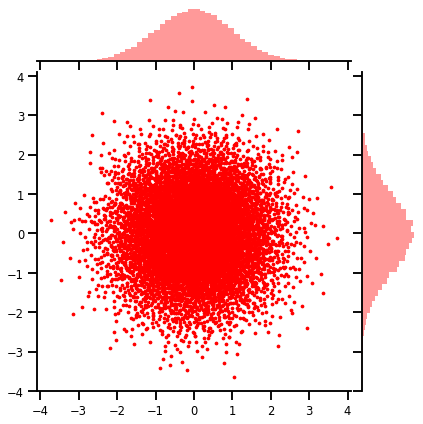

In [176]:
sns.jointplot(X_g[:, 0], X_g[:, 1], s=5, color='red')

### Forward Transformation

In [177]:
%%time
X_g = rbig_clf.transform(data)

CPU times: user 741 ms, sys: 90.8 ms, total: 831 ms
Wall time: 170 ms


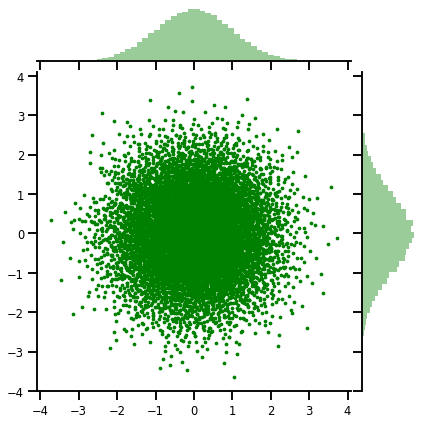

In [178]:
sns.jointplot(X_g[:, 0], X_g[:, 1], s=5, color='green')

### Inverse Transformation

In [179]:
%%time
X_approx = rbig_clf.inverse_transform(X_g)

CPU times: user 526 ms, sys: 198 ms, total: 724 ms
Wall time: 326 ms


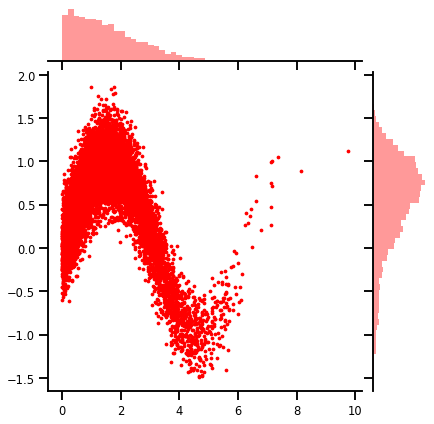

In [180]:
sns.jointplot(X_approx[:, 0], X_approx[:, 1], s=5, color='red')

### Sampling

In [181]:
%%time
X_samples = rbig_clf.sample(10_000)

CPU times: user 563 ms, sys: 168 ms, total: 731 ms
Wall time: 332 ms


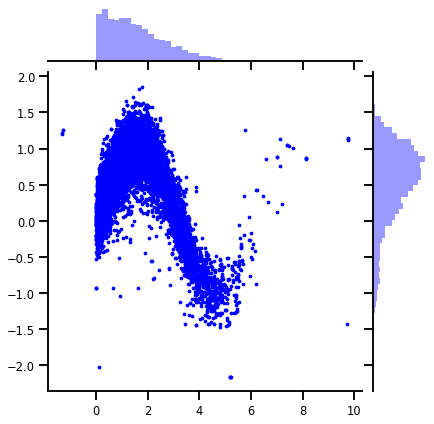

In [182]:
sns.jointplot(X_samples[:, 0], X_samples[:, 1], s=5, color='blue')